# Setup

In [1]:
import os
import io
from typing import Tuple, List, Dict

import numpy
import sklearn as sklearn
import torch
import torchvision.models
import tqdm as tqdm
from torch.nn import CrossEntropyLoss, BCELoss
from torch.optim import SGD
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from IPython.display import display

from tqdm.notebook import tqdm

In [2]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
import importlib
from orientation_nn import OrientationImageFolder
import orientation_nn
importlib.reload(orientation_nn)
from orientation_nn import OrientationCNN

# %load_ext autoreload # %autoreload 1 # %aimport orientation_nn

In [4]:
# model = None
# load model from .pt
model = OrientationCNN()
# model.load_state_dict(torch.load("model-Dcheck.pt"))
model = model.to(device)

# model2 = torchvision.models.densenet161()
# model2.classifier = nn.Linear(2208, 2)

In [5]:
dataset = OrientationImageFolder('../iamdataset/sentences-sample')

In [20]:
train_transform = transforms.Compose([
    # transforms.RandomCrop(224, padding=50),
    # transforms.RandomResizedCrop(112, scale=(0.08, 0.25)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32), # (32, 256)),
    # orientation_nn.PadToSize((256,32), pad_with=999999), #LOL if you put "1" it will pad with 0.00392157 but if you put a really big number then it will work. Real bruh moment

    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((180, 180)),
    # transforms.RandomInvert(p=1),
    # transforms.RandomInvert(p=1),
    orientation_nn.PadToSize((224,224), pad_with=255, center=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # get transforms from densenet161
    # torchvision.models.DenseNet161_Weights.DEFAULT.transforms()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomInvert(p=0),
    transforms.ToTensor()
])
dataset.transform = train_transform

# loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
from torch.utils.data import DataLoader


# test/train split
# prepare the dataset
def prepare_data(dataset):
    # define standardization
    # trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # load dataset
    _datalen = len(dataset)
    _trainlen = int(_datalen * .8)
    train_set, test_set = torch.utils.data.random_split(dataset, [_trainlen, _datalen - _trainlen])

    # prepare data loaders
    train_dl = DataLoader(train_set, batch_size=4, shuffle=True)
    test_dl = DataLoader(test_set, batch_size=16, shuffle=False)
    return train_dl, test_dl
train_dl, test_dl = prepare_data(dataset)

torch.Size([4, 3, 224, 224]) torch.Size([4])
label: flipped


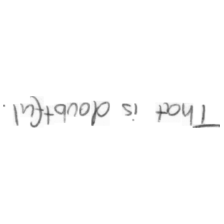

label: normal


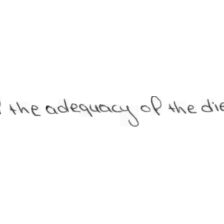

label: flipped


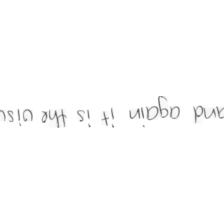

label: flipped


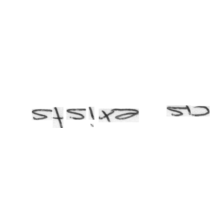

torch.Size([4, 3, 224, 224]) torch.Size([4])
label: normal


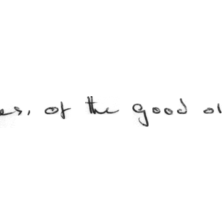

label: flipped


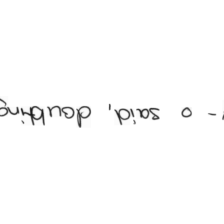

label: flipped


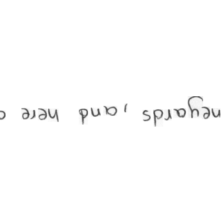

label: normal


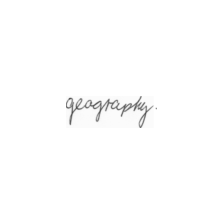

torch.Size([4, 3, 224, 224]) torch.Size([4])
label: normal


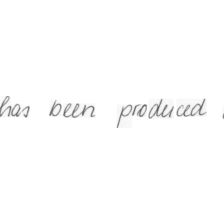

label: flipped


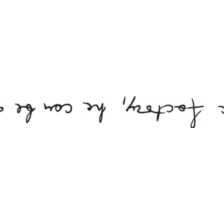

label: normal


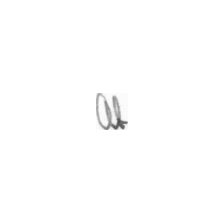

label: normal


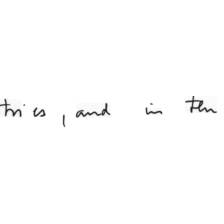

torch.Size([4, 3, 224, 224]) torch.Size([4])
label: normal


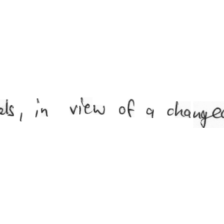

label: normal


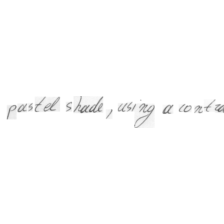

label: normal


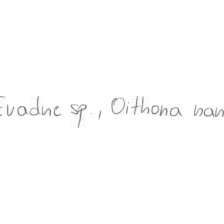

label: flipped


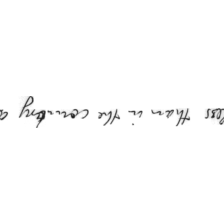

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [19]:
last = None
def peek(train_dl):
    # test it out by taking a peek
    for _ in range(4):
        img1b, lbl = next(iter(train_dl))
            # img1 = F.to_pil_image(train_set.__getitem__(5)[0])
            # print(img1, lbl)
        print(img1b.shape, lbl.shape)
        for i, img1 in enumerate(img1b):
            img1 = F.to_pil_image(img1b[i]) # , mode='L') # grayscale
            # img1.show()
            print(f"label: {'flipped' if lbl[i] else 'normal'}")
            # print(img1b[i])
            display(img1)
            global last
            last = img1b[i]

peek(train_dl)
print(last)
# print(last.numpy())

In [103]:
import torch.nn as nn

In [109]:


# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    # criterion = BCELoss()
    # m = nn.Sigmoid()
    optimizer = torch.optim.Adam(model.parameters()) # , lr=0.01, momentum=0.9)
    # enumerate epochs
    # add progress bar

    NUM_EPOCHS = 10
    for epoch in range(NUM_EPOCHS):
        # enumerate mini batches
        loop = tqdm(train_dl)
        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")

        train_loss = 0
        train_acc = 0
        atts = 0
        for i, (inputs, targets) in enumerate(loop):
            # https://aladdinpersson.medium.com/how-to-get-a-progress-bar-in-pytorch-72bdbf19b35c


            optimizer.zero_grad() # clear the gradients
            yhat = model(inputs) # compute the model output
            loss = criterion(yhat, targets) # , targets.reshape(-1, 1)) # calculate loss

            # predicted = model(torch.tensor(inputs,dtype=torch.float32))
            # acc = (predicted.reshape(-1).detach().numpy().round() == targets).mean()

            loss.backward() # credit assignment
            optimizer.step()  # update model weights

            train_loss += loss.item()*inputs.size(0)
            train_acc += (yhat.argmax(1) == targets).sum().item()
            atts += inputs.size(0)
            if atts % 1000 == 0:
                print(f"train_loss: {train_loss/atts}, train_acc: {train_acc/atts}")

        # loop.set_postfix(loss=train_loss/len(train_dl.sampler), acc=train_acc/len(train_dl.sampler))
        print(f"train_loss: {train_loss/len(train_dl.sampler)}, train_acc: {train_acc/len(train_dl.sampler)}")
        # save the model
        torch.save(model.state_dict(), f'model-E.{epoch}.pt')


In [111]:
# prepare the data
# path = '~/.torch/datasets/mnist'
train_dl, test_dl = prepare_data('')
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
if model is None:
    print('reset!')
    model = OrientationCNN()
# # train the model
train_model(train_dl, model)
# evaluate the model
# acc = evaluate_model(test_dl, model)
# print('Accuracy: %.3f' % acc)

26803 6701


  0%|          | 0/6701 [00:00<?, ?it/s]

KeyboardInterrupt: 

On googling "0.6931471824645996":
https://github.com/pytorch/pytorch/issues/11752


In [54]:

# get element 5618 of train_dl and run it through the model
ele, target = train_dl.dataset.__getitem__(604)
# run it through model
result = model(ele[0].unsqueeze(0)).detach().numpy()
print(result)
print(target)
# ele

[[ 0. -0.]]
0


In [92]:
print(model)
# get shape of tensor of dataset
print(dataset[0][0].shape)

from torchsummary import summary

# train_dl has torch.Size([4, 3, 32, 256]) with batch_size = 4
summary(model, (1, 32, 128))

OrientationCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
torch.Size([1, 32, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 32, 128]             320
            Conv2d-2           [-1, 64, 16, 64]          18,496
            Conv2d-3           [-1, 128, 8, 32]          73,856
            Linear-4                  [-1, 128]       2,097,280
           Dropout-5                  [-1, 128]               0
            Linear-6                  [-1, 128] 

In [19]:
# load model from .pt file
# model = OrientationCNN()
# model.load_state_dict(torch.load('model_scripted.pt'))
# model.eval()
model = torch.jit.load('model_scripted.pt')

In [58]:
from sklearn.metrics import accuracy_score
from numpy import vstack


# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    loop = tqdm(test_dl)
    loop.set_description(f"Evaluating model")
    for i, (inputs, targets) in enumerate(loop):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [59]:
evaluate_model(test_dl, model)

  0%|          | 0/419 [00:00<?, ?it/s]

ValueError: Classification metrics can't handle a mix of binary and multiclass-multioutput targets